In [1]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from functools import reduce
import seaborn as sns
from sklearn import preprocessing
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from random import randrange

from random import seed
from random import random
from matplotlib import pyplot
import pandas
from pandas.plotting import autocorrelation_plot
from keras import Model
from keras.layers import GRU, Dense, Input
%matplotlib inline

from numpy.random import seed as np_seed
from tensorflow import set_random_seed


SEED = 42

seed(SEED)
np_seed(SEED)
set_random_seed(SEED)


path = '../data/'




In [2]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')


#Problems when remove index category because of multi index
#df_sds011['location'] = df_sds011['location'].astype('category')
#df_dht22['location'] = df_dht22['location'].astype('category')

df_sds011 = df_sds011.set_index(['location', 'timestamp'])
df_dht22 = df_dht22.set_index(['location', 'timestamp'])

df_sds011 = df_sds011.sort_index()
df_dht22 = df_dht22.sort_index()

df_sds011 = df_sds011[['P1', 'P2']]
df_dht22 = df_dht22[['temperature', 'humidity']]

In [ ]:
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

In [ ]:
df_sds011.describe()

In [ ]:
df_dht22.describe()

In [ ]:
_ = df_dht22.boxplot(by='location')
_ = df_sds011.boxplot(by='location')

In [ ]:
df_sds011.groupby(level=0).plot(kind='kde')

In [ ]:
df_dht22.groupby(level=0).plot( kind='kde')

# Outliers

In [3]:
def remove_outlier(df):
    print(df.groupby(level=0).count())
    res = df[np.abs(df - df.mean()) <= (3*df.std())]
    print(res.groupby(level=0).count())
    
    return res


df_sds011 = remove_outlier(df_sds011)
df_dht22 = remove_outlier(df_dht22)

              P1      P2
location                
3123      264096  264096
3642      248374  248374
6367      161817  161817
8732       65543   65543
10574         13      13
              P1      P2
location                
3123      255362  262367
3642      247752  248098
6367      161382  161655
8732       59956   54356
10574         13      13
          temperature  humidity
location                       
3123           266982    266982
3642           248466    248466
6367           162158    162158
8732            65560     65560
10574              13        13
          temperature  humidity
location                       
3123           266692    266982
3642           246017    248466
6367           158905    161820
8732            65560     65560
10574              13        13


In [ ]:
df_sds011.describe()

In [ ]:
df_dht22.describe()

In [ ]:
#_ = df_dht22.boxplot(by='location')
#_ = df_sds011.boxplot(by='location')

In [ ]:
df_sds011.groupby(level=0).plot(kind='kde')

In [ ]:
df_dht22.groupby(level=0).plot(kind='kde')

In [ ]:
df_sds011.groupby(level=0).describe()

In [ ]:
df_dht22.groupby(level=0).describe()

# Drop unnecessary  data 

In [4]:
df_sds011 = df_sds011.drop([3123, 10574], level=0)
df_dht22 = df_dht22.drop([3123, 10574], level=0)

# Normalize and Stand

In [ ]:
# through normalization, correlations can be better observerd

df_sds011[['P1', 'P2']] =  preprocessing.normalize(df_sds011[['P1', 'P2']], axis=0, norm='max')
scaler = preprocessing.StandardScaler()
df_sds011[['P1', 'P2']] = scaler.fit_transform(df_sds011[['P1', 'P2']])

df_dht22[['temperature', 'humidity']] = preprocessing.normalize(df_dht22[['temperature', 'humidity']], axis=0, norm='max')
scaler = preprocessing.StandardScaler()
df_dht22[['temperature', 'humidity']] = scaler.fit_transform(df_dht22[['temperature', 'humidity']])

In [ ]:
print(df_sds011.describe())
print(df_dht22.describe())

# Resample and Merge

In [5]:
def resample(df, freq='60min'):
    level_values = df.index.get_level_values
    return df.groupby([level_values(0)] + [pd.Grouper(freq=freq, level=1)]).mean().dropna()

In [6]:

df_sds011 = resample(df_sds011)
df_dht22 = resample(df_dht22)

In [ ]:
print(df_sds011.shape, df_dht22.shape)

In [7]:
data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
data = data[data.humidity <= 70.0]
print(data.shape)

(8870, 4)


In [ ]:

alpha = list(data.columns.values)

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()



In [ ]:
df_dht22[['temperature']].hist(bins=50, by='location')

In [ ]:
df_dht22[['humidity']].hist(bins=50, by='location')

In [ ]:
bins = int(len(range(int(df_sds011['P1'].min()), int(df_sds011['P1'].max()))) / 5 )
df_sds011[['P1']].hist(bins=bins, by='location')

In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 50

f, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

groups = list(df_sds011.groupby(level=0))


sns.distplot(groups[0][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text(groups[0][0])

sns.distplot(groups[1][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text(groups[1][0])

sns.distplot(groups[2][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text(groups[2][0])


    
plt.tight_layout()
    


In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 15


f, axes = plt.subplots(3, 2, figsize=(10, 7), sharex=True)

#data gets average over location 

#d = data[data['P1'] <= 15]
d = data
sns.distplot(d[['P1']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text('P1')

sns.distplot(d[['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text('P2')


sns.distplot(boxcox(d[['P1']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text('P1 boxcox')

sns.distplot(boxcox(d[['P2']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,1])

axes[1,1].title.set_text('P2 boxcox')

sns.distplot(d[['temperature']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,0])

axes[2,0].title.set_text('Temperature')

sns.distplot(d[['humidity']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,1])

axes[2,1].title.set_text('Humidity')

    
plt.tight_layout()
    

# Time Series

In [8]:

 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
#remove location as index, leaving only timestamp
data = data.groupby(level=1).mean().sort_index()[['P1', 'P2', 'temperature', 'humidity']]

In [13]:
data = data[['humidity', 'temperature', 'P1']]
data = series_to_supervised(data, n_in=1, n_out=1, dropnan=True)

In [46]:

X = data[['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var1(t)', 'var2(t)']]
y = data[['var3(t)']]

X_train, X_test, y_train, y_test = train_test_split(X.values,y.values, test_size=0.2, shuffle=False)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train.shape, X_test.shape, y_train.shape

((7095, 1, 5), (1774, 1, 5), (7095, 1))

In [52]:
def create_model(batch_size):
    inp = Input(batch_shape=(batch_size,1,5))
    x = GRU(10, stateful=True)(inp)
    x = Dense(1)(x)

    model = Model(inp, x)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

train_model = create_model(5)
test_model = create_model(2)

results = []

for i in range(2):
    train_model.fit(X_train, y_train, epochs=1, shuffle=False, batch_size=5)
    train_model.reset_states()
    
    test_model.set_weights(train_model.get_weights())
    res = test_model.evaluate(X_test, y_test, batch_size=2)
    print(res)
    results.append(res)


# fit network
#for i in range(n_epoch):
#model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
#model.reset_states()

Epoch 1/1
4520/7095 [==================>...........] - ETA: 1s - loss: 281.9030

KeyboardInterrupt: 

In [ ]:
print(results[-1])

# Check for Random Walk, Stationarity ...

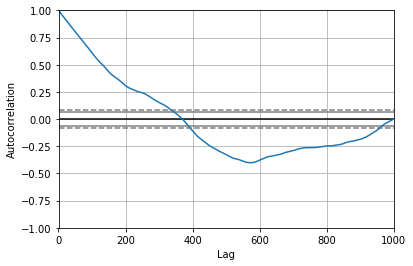

In [345]:


seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
#pyplot.plot(random_walk)
autocorrelation_plot(random_walk)
pyplot.show()

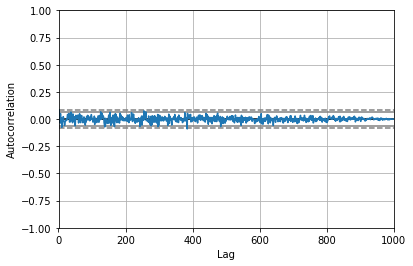

In [347]:

series = [randrange(10) for i in range(1000)]
autocorrelation_plot(series)


In [371]:

# statistical test
result = adfuller(d['temperature'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.633108
p-value: 0.086346
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


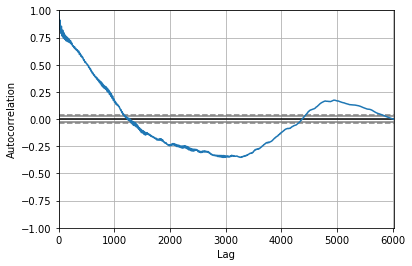

In [370]:
autocorrelation_plot(d['temperature'])

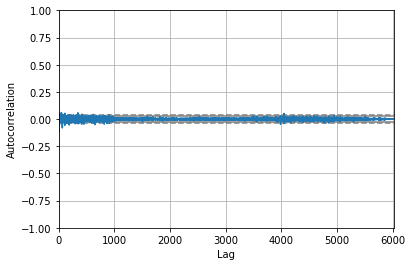

In [367]:
values = []
for t in range(1, len(d['P1'])):
    value = d['P1'].values[t] - d['P1'].values[t - 1]
    values.append(value)

#pyplot.plot(values)
#pyplot.show()
autocorrelation_plot(values)